In [219]:
import re
import nltk
import random
import numpy as np
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# Load data

In [28]:
import pandas as pd
df = pd.read_csv('drug_dataset.csv')
df = pd.DataFrame(df)
df['title']

0                       Why is this medication prescribed?
1                        How should this medicine be used?
2                             Other uses for this medicine
3                What special precautions should I follow?
4        What special dietary instructions should I fol...
                               ...                        
17738                What other information should I know?
17739                                          Brand names
17740                        In case of emergency/overdose
17741                What other information should I know?
17742                                          Brand names
Name: title, Length: 17743, dtype: object

# Take unique titles

In [29]:
titles = set(df['title'].str.lower())
sentences = list(titles)
len(sentences)

136

# Analyze Our Vocabulary 

In [220]:
stemmer = nltk.stem.SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [225]:
word_list = [] 
sentence_list = []
stemmed_sentence_list = []
stemmed_words = []
remove_pattern = '[\(\):\?0-9.,]'
split_pattern = '/| |-|—'

for sentence in sentences:
    word_in_sentence = re.split(split_pattern, sentence)
    word_in_sentence = [re.sub(remove_pattern, '', word) for word in word_in_sentence if len(re.sub(remove_pattern, '', word)) > 1]
    stemmed_words_in_sentence = [stemmer.stem(lemmatizer.lemmatize(word)) for word in word_in_sentence]
    sentence_list.append(word_in_sentence)
    word_list += word_in_sentence 
    stemmed_sentence_list.append(stemmed_words_in_sentence)
    stemmed_words += stemmed_words_in_sentence 

len(word_list)

824

In [227]:
word_set = list(set(word_list))
stemmed_word_set = list(set(stemmed_words))
len(word_set)

164

In [228]:
len(stemmed_word_set)

156

In [36]:
stop_words = set(stopwords.words('english'))

In [230]:
common_words = [word for word in word_set if word in stop_words]
rare_words = [word for word in word_set if word not in stop_words]
stemmed_common_words = [word for word in word_set if word in stop_words]
stemmed_rare_words = [word for word in stemmed_word_set if word not in stop_words]

print(f"Number of unique words: {len(word_set)}\n\
Number of stop words in out dictionary: {len(common_words)}\n\
Number of rare words in out dictionary: {len(rare_words)}\n\
Number of stemmed stop words in out dictionary: {len(stemmed_common_words)}\n\
Number of stemmed rare words in out dictionary: {len(stemmed_rare_words)}")

Number of unique words: 164
Number of stop words in out dictionary: 37
Number of rare words in out dictionary: 127
Number of stemmed stop words in out dictionary: 37
Number of stemmed rare words in out dictionary: 120


## Pretrained Word2Vec

In [79]:
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

In [72]:
out_of_vocabulary = ['laiv', 'pcv', 'ipv', 'ppsv', 'moderna', 'mmr', 'covid', 'tdap', 'biontech', 'hib', 'janssen', 'dtap']
rare_vectors = [word2vec_model[rare_word] for rare_word in rare_words if rare_word not in out_of_vocabulary]
rare_vectors = np.array(rare_vectors)

In [4]:
rare_vectors.shape

(115, 300)

In [18]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(rare_vectors)
reduced_data.shape

(115, 2)

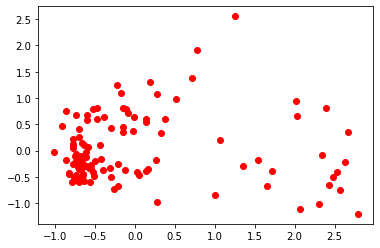

In [19]:
plt.scatter(reduced_data.T[0], reduced_data.T[1], marker='o', color='r')

## Training Word2Vec Model

In [72]:
from gensim.models import Word2Vec

In [271]:
trained_model = Word2Vec(size=300, window=5, min_count=1)
trained_model.build_vocab(stemmed_sentence_list)
trained_model.train(stemmed_sentence_list, total_examples=trained_model.corpus_count, epochs=1000)

(346381, 824000)

In [272]:
rare_vectors = [trained_model[word] for word in stemmed_rare_words]
rare_vectors = np.array(rare_vectors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [273]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(rare_vectors)
reduced_data.shape

(120, 2)

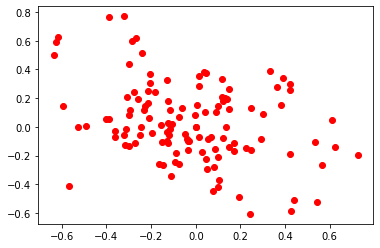

In [274]:
plt.scatter(rare_vectors.T[0], rare_vectors.T[1], marker='o', color='r')

## Vocabulary clustering

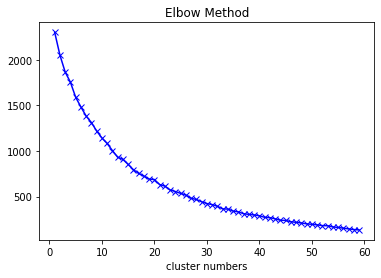

In [275]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(rare_vectors)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [276]:
n_clusters = 30

km = KMeans(n_clusters=n_clusters)

km.fit(rare_vectors)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  30  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 30, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [277]:
clusters = {}

for i, word in enumerate(stemmed_rare_words):
    if km.predict(rare_vectors[i].reshape(-1, 1).T)[0] in clusters.keys():
      clusters[km.predict(rare_vectors[i].reshape(-1, 1).T)[0]].append(word)
    else:
      clusters[km.predict(rare_vectors[i].reshape(-1, 1).T)[0]] = [word]

clusters

{0: ['administr', 'fee', 'charg'],
 1: ['warn', 'import', 'topic', 'relat'],
 2: ['nation', 'compens', 'injuri', 'program', 'countermeasur'],
 3: ['hpv', 'td', 'tdap', 'ipv', 'group', 'hib'],
 4: ['notic',
  'diseas',
  'vaccin',
  'japanes',
  'drug',
  'mmr',
  'enceph',
  'chickenpox',
  'supplement',
  'herb',
  'avail',
  'rotavirus'],
 5: ['janssen', 'johnson'],
 6: ['dispos', 'storag', 'know'],
 7: ['effect', 'side', 'caus'],
 8: ['emerg', 'case', 'report', 'overdos', 'fraud', 'suspect'],
 9: ['special', 'instruct', 'precaut', 'dietari', 'follow'],
 10: ['combin', 'name', 'product'],
 11: ['moder', 'sever', 'problem', 'serious', 'reaction'],
 12: ['dose', 'forget'],
 13: ['pfizer', 'moderna', 'biontech'],
 14: ['child', 'dtap', 'peopl', 'babi'],
 15: ['recombin', 'live'],
 16: ['card',
  'talk',
  'provid',
  'care',
  'health',
  'treatment',
  'keep',
  'doctor'],
 17: ['tell', 'person'],
 18: ['yellow', 'fever', 'prevent', 'learn'],
 19: ['je', 'typhoid', 'meningococc', 'hepa

<BarContainer object of 30 artists>

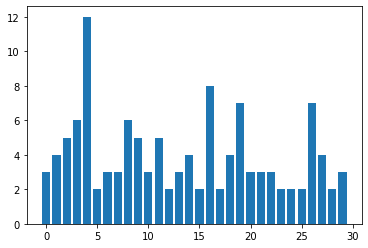

In [278]:
plt.bar(list(clusters.keys()), [len(value) for value in clusters.values()])

# Sentence Clustering

## Randomly choose 30 samples of a data

In [ ]:
test_cases = random.sample(range(0, len(sentences) - 1), 30)

In [ ]:
model = SentenceTransformer('paraphrase-mpnet-base-v2')

In [ ]:
sentence_embeddings = model.encode(sentences)

In [ ]:
# sentence_embeddings[0]
sentence_embeddings.shape

(136, 768)

## Without dimensionality reduction

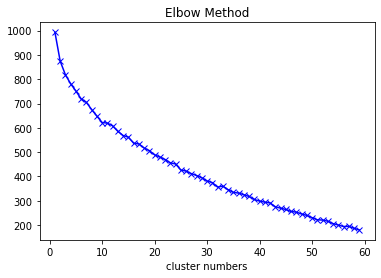

In [ ]:
SSE = []

for k in range(1, 60):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(sentence_embeddings)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 60), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [ ]:
# Hyperparameter 1
n_clusters = 10

km = KMeans(n_clusters=n_clusters)

km.fit(sentence_embeddings)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  10  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [ ]:
for i in test_cases:
    print(sentences[i], km.predict(sentence_embeddings[i].reshape(-1, 1).T))

rotavirus vaccine [0]
what if there is a serious problem? [8]
who should get this hpv vaccine and when? [4]
some babies should not get this vaccine [4]
notice: [9]
what are the benefits of the moderna covid-19 vaccine? [6]
will the pfizer-biontech covid-19 vaccine give me covid-19? [6]
what is td vaccine? [0]
other uses for this medicine [7]
what is hib vaccine? [0]
other names [3]
where will my vaccination information be recorded? [0]
what are the benefits of the janssen (johnson and johnson) vaccine? [2]
mmr vaccine [0]
what are the risks from this vaccine? [2]
important warning:  [9]
how is the janssen (johnson and johnson) covid-19 vaccine given? [6]
what should you tell the person who is giving the vaccine? [4]
how is the pfizer-biontech covid-19 vaccine given? [6]
the national vaccine injury compensation program [2]
injury compensation [5]
what are the risks from typhoid vaccine? [2]
what is anthrax vaccine? [0]
cholera vaccine [2]
related topics [3]
who should not get ipv or sho

## Using combinition of dimensionality reduction and clustering

### Credit:
    - https://stats.stackexchange.com/a/256173/276359
    - https://stats.stackexchange.com/a/99191/276359

## With PCA **bold text**

In [ ]:
# Hyperparameter 1 
n_dimention = 10
pca = PCA(n_components=n_dimention)
reduced_data = pca.fit_transform(sentence_embeddings)

In [ ]:
reduced_data.shape

(136, 10)

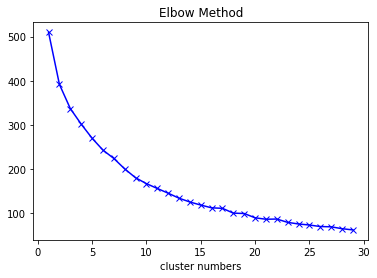

In [ ]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [ ]:
# Hyperparameter 2
n_clusters = 7

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  7  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 7, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [ ]:
len(centers[0])

10

In [ ]:
for i in test_cases:
    print(sentences[i], km.predict(reduced_data[i].reshape(-1, 1).T))

rotavirus vaccine [0]
what if there is a serious problem? [3]
who should get this hpv vaccine and when? [4]
some babies should not get this vaccine [4]
notice: [2]
what are the benefits of the moderna covid-19 vaccine? [1]
will the pfizer-biontech covid-19 vaccine give me covid-19? [1]
what is td vaccine? [0]
other uses for this medicine [6]
what is hib vaccine? [0]
other names [5]
where will my vaccination information be recorded? [0]
what are the benefits of the janssen (johnson and johnson) vaccine? [1]
mmr vaccine [0]
what are the risks from this vaccine? [1]
important warning:  [2]
how is the janssen (johnson and johnson) covid-19 vaccine given? [1]
what should you tell the person who is giving the vaccine? [4]
how is the pfizer-biontech covid-19 vaccine given? [1]
the national vaccine injury compensation program [1]
injury compensation [3]
what are the risks from typhoid vaccine? [1]
what is anthrax vaccine? [0]
cholera vaccine [0]
related topics [5]
who should not get ipv or sho

## With T-SNE (method = exact)

In [ ]:
# Hyperparameter 1 
n_dimention = 10
tsne = TSNE(n_components=n_dimention, method='exact')
reduced_data = tsne.fit_transform(sentence_embeddings)

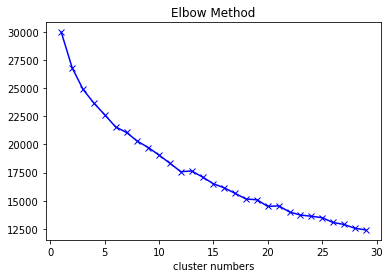

In [ ]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [ ]:
# Hyperparameter 2
n_clusters = 7

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  7  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 7, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [ ]:
for i in test_cases:
    print(sentences[i], km.predict(reduced_data[i].reshape(-1, 1).T))

rotavirus vaccine [4]
what if there is a serious problem? [4]
who should get this hpv vaccine and when? [4]
some babies should not get this vaccine [1]
notice: [3]
what are the benefits of the moderna covid-19 vaccine? [4]
will the pfizer-biontech covid-19 vaccine give me covid-19? [1]
what is td vaccine? [6]
other uses for this medicine [1]
what is hib vaccine? [2]
other names [2]
where will my vaccination information be recorded? [2]
what are the benefits of the janssen (johnson and johnson) vaccine? [0]
mmr vaccine [6]
what are the risks from this vaccine? [3]
important warning:  [0]
how is the janssen (johnson and johnson) covid-19 vaccine given? [0]
what should you tell the person who is giving the vaccine? [3]
how is the pfizer-biontech covid-19 vaccine given? [1]
the national vaccine injury compensation program [6]
injury compensation [1]
what are the risks from typhoid vaccine? [6]
what is anthrax vaccine? [1]
cholera vaccine [6]
related topics [3]
who should not get ipv or sho

## With T-SNE (method = barnes_hut)

In [ ]:
# Hyperparameter 1 
# Barnes–Hut method works only with less than 4 dimensions
n_dimention = 3
tsne = TSNE(n_components=n_dimention, method='barnes_hut')
reduced_data = tsne.fit_transform(sentence_embeddings)

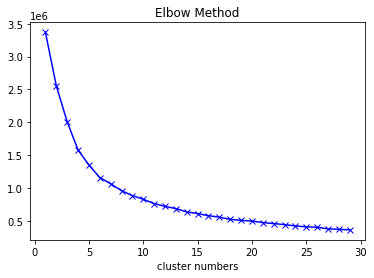

In [ ]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [ ]:
# Hyperparameter 2
n_clusters = 5

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  5  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [ ]:
for i in test_cases:
    print(sentences[i], km.predict(reduced_data[i].reshape(-1, 1).T))

rotavirus vaccine [1]
what if there is a serious problem? [1]
who should get this hpv vaccine and when? [3]
some babies should not get this vaccine [2]
notice: [0]
what are the benefits of the moderna covid-19 vaccine? [3]
will the pfizer-biontech covid-19 vaccine give me covid-19? [3]
what is td vaccine? [2]
other uses for this medicine [4]
what is hib vaccine? [3]
other names [4]
where will my vaccination information be recorded? [4]
what are the benefits of the janssen (johnson and johnson) vaccine? [3]
mmr vaccine [1]
what are the risks from this vaccine? [4]
important warning:  [0]
how is the janssen (johnson and johnson) covid-19 vaccine given? [2]
what should you tell the person who is giving the vaccine? [1]
how is the pfizer-biontech covid-19 vaccine given? [3]
the national vaccine injury compensation program [4]
injury compensation [4]
what are the risks from typhoid vaccine? [0]
what is anthrax vaccine? [1]
cholera vaccine [1]
related topics [0]
who should not get ipv or sho